# Modèle mono vue Recto Verso

Installation des packages

In [1]:
from dotenv import load_dotenv, find_dotenv
import numpy as np
import datetime, os
import tarfile
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, array_to_img, img_to_array, load_img, image_dataset_from_directory
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import datetime

In [14]:
tf.config.run_functions_eagerly(True)

In [2]:
load_dotenv(find_dotenv())
PATH_TO_SMALL_ROI_TYP_FOR_KERAS = os.environ.get("PATH_TO_SMALL_ROI_TYP_FOR_KERAS")
PATH_TO_SMALL_ROI_TYP_FOR_KERAS

RECTO_PATH = join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS, 'RECTO')
VERSO_PATH = join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS, 'VERSO')


In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
BATCH_SIZE = 32
CLASSES = 8

In [4]:
trainR  = image_dataset_from_directory(RECTO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

valR = image_dataset_from_directory(RECTO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

trainV  = image_dataset_from_directory(VERSO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

valV = image_dataset_from_directory(VERSO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

Found 2301 files belonging to 7 classes.
Using 1841 files for training.
Found 2301 files belonging to 7 classes.
Using 460 files for validation.
Found 2301 files belonging to 7 classes.
Using 1841 files for training.
Found 2301 files belonging to 7 classes.
Using 460 files for validation.


In [36]:
X_train_R = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_train_recto = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in trainR:
    X_train_R = tf.concat([X_train_R,recto[0]],0)
    y_train_recto = tf.concat([y_train_recto,recto[1]],0)

X_train_V = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_train_verso = tf.zeros(shape=(32,),dtype=tf.int32)
for verso in trainV:
    X_train_V = tf.concat([X_train_V,verso[0]],0)
    y_train_verso = tf.concat([y_train_recto,recto[1]],0)

X_test_V = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_test_verso = tf.zeros(shape=(32,),dtype=tf.int32)
for verso in valV:
    X_test_V = tf.concat([X_test_V,verso[0]],0)
    y_test_verso = tf.concat([y_test_verso,verso[1]],0)

X_test_R = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_test_recto = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in valR:
    X_test_R = tf.concat([X_test_R,recto[0]],0)
    y_test_recto = tf.concat([y_test_recto,recto[1]],0)



train = tf.concat([X_train_R, X_train_V], 0)
test = tf.concat([X_test_R, X_test_V], 0)
y_train = tf.concat([y_train_recto, y_train_verso], 0)
y_test = tf.concat([y_test_recto, y_test_verso], 0)

In [6]:
# Creation du modèle de base à partir du modèle pré-entraîné EffB3
base_model = tf.keras.applications.EfficientNetB5(input_shape=INPUT_SHAPE,
include_top=False,
weights='imagenet')

In [7]:
base_model.trainable = False

In [8]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
inputs1 = tf.keras.Input(shape=(224, 224, 3))
x1 = preprocess_input(inputs1)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)

x = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(x1)
outputs = x
model = tf.keras.Model(inputs=inputs1, outputs=outputs)

In [9]:
base_learning_rate = 10**(-3)
model.compile(optimizer=tf.keras.optimizers.
Adam(learning_rate=base_learning_rate),
loss="sparse_categorical_crossentropy",
metrics = ['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 28,529,919
Trainable params: 16,392
Non-trainable params: 28,513,527
____________________________________________

In [11]:
initial_epochs = 30
history = model.fit(train,
y= y_train,
batch_size=BATCH_SIZE,
epochs=initial_epochs,
validation_split=0.2,
shuffle=True
)

Epoch 1/30
94/94 [==============================] - 325s 3s/step - loss: 0.9070 - accuracy: 0.7276 - val_loss: 0.5715 - val_accuracy: 0.8267
Epoch 2/30
94/94 [==============================] - 312s 3s/step - loss: 0.4394 - accuracy: 0.8812 - val_loss: 0.4353 - val_accuracy: 0.8680
Epoch 3/30
94/94 [==============================] - 306s 3s/step - loss: 0.3329 - accuracy: 0.9146 - val_loss: 0.3693 - val_accuracy: 0.8973
Epoch 4/30
94/94 [==============================] - 307s 3s/step - loss: 0.2738 - accuracy: 0.9262 - val_loss: 0.3339 - val_accuracy: 0.9000
Epoch 5/30
94/94 [==============================] - 307s 3s/step - loss: 0.2365 - accuracy: 0.9393 - val_loss: 0.3101 - val_accuracy: 0.9067
Epoch 6/30
94/94 [==============================] - 307s 3s/step - loss: 0.2066 - accuracy: 0.9476 - val_loss: 0.2876 - val_accuracy: 0.9173
Epoch 7/30
94/94 [==============================] - 307s 3s/step - loss: 0.1869 - accuracy: 0.9546 - val_loss: 0.2731 - val_accuracy: 0.9160
Epoch 8/30
94

In [12]:
base_path = r"C:\Users\badrk\Documents\ENSAI\PFE\pfe-deep-learning-maladies-plantes"
path_to_save = os.path.join(base_path,"save_models/mono_view/",f'ECHANT_recto_verso_EfficientNetB5_batch_size_{BATCH_SIZE}.h5')

In [13]:
model.save_weights(path_to_save,save_format='h5')

# Plot training

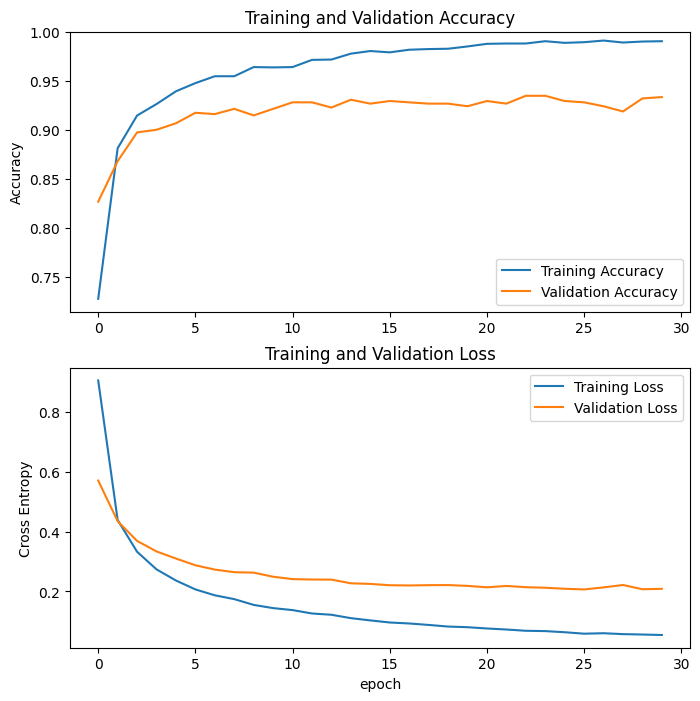

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Evaluation

In [20]:
print(test)

tf.Tensor(
[[[[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  ...

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   ...
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.    

In [18]:
model.evaluate(x=test,y=y_test,batch_size=BATCH_SIZE)

ValueError: Data cardinality is ambiguous:
  x sizes: 984
  y sizes: 524
Make sure all arrays contain the same number of samples.